In [1]:
import os
# Obtiene el nuevo directorio actual después del cambio
new_directory = '/Users/jyoung/Doctorado/embryo_classification/'
os.chdir(new_directory)
print("New actual directory:", new_directory)

# Elimino warnings molestas
import warnings
warnings.filterwarnings("ignore")

New actual directory: /Users/jyoung/Doctorado/embryo_classification/


# Libraries

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import cv2 as cv
import cv2
import os
import torchvision.models as models
import torch.optim as optim
import tqdm
import torch.nn.functional as F  # Functions without parameters for neural network operations
import torchvision.models as models
import tensorflow.keras as keras

from tensorflow.keras import optimizers
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from torch.utils.data import Dataset, DataLoader, sampler
from sklearn.model_selection import KFold  # K-Folds cross-validator for model evaluation
from typing import Tuple, List, Union  # Typing for type hinting in function signatures
from torch.cuda.amp import autocast  # Automatic mixed precision training in PyTorch
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from models import Model_Unet
from models.Model_Unet import build_model
from models.Model_Unet import iou_score, bce_jaccard_loss
from skimage.transform import resize
from skimage.segmentation import flood, flood_fill
from IPython.display import clear_output
from PIL import Image


2024-01-16 02:45:38.315303: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Functions

In [3]:
%run utils/segmentation_functions.py

In [4]:
def model_loader(zone):
    img_size_target = 256
    input_layer = Input((img_size_target, img_size_target, 1))
    output_layer = build_model(input_layer, 16,0.05)
    lr=.0001
    model = Model(input_layer, output_layer)
    opt = optimizers.Adam(lr)
    model.compile(optimizer='Nadam', loss=bce_jaccard_loss, metrics=[iou_score])

    model.load_weights('models/model-RDUNET_'+str(zone)+'.h5')
    return model

def train_one_epoch(model : torch.nn.Module,
                    optimizer : torch.optim.Optimizer,
                    data_loader : torch.utils.data.DataLoader,
                    device : str,
                    dtype : type = torch.float32,
                    scaler : torch.cuda.amp.GradScaler = None ) -> Tuple[float, float]:
    """
    Trains the model for one epoch using the provided data_loader.

    Args:
    - model: The neural network model to be trained.
    - optimizer: The optimizer used for training the model.
    - data_loader: The data loader providing training data.
    - device: The device on which the training will be performed (e.g., 'cpu' or 'cuda').
    - dtype (torch.dtype, optional): The data type used for the tensors (default: torch.float32).
    - scaler (torch.cuda.amp.GradScaler, optional): Gradient scaler for mixed precision training (default: None).

    Returns:
    - tuple: A tuple containing the average loss per sample and the accuracy for the epoch.
    """
    model.train()
    total_loss = 0.0
    correct = 0
    total_samples = 0

    for x, y in tqdm(data_loader):
        x, y = x.to(device=device, dtype=dtype), y.to(device=device, dtype=torch.long)
        optimizer.zero_grad()
        with autocast(enabled=(scaler is not None)):
            scores = model(x)
            loss = F.cross_entropy(scores, y)
        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * x.size(0)
        _, predicted = scores.max(1)
        correct += (predicted == y).sum().item()
        total_samples += x.size(0)

    return total_loss / total_samples, correct / total_samples


def accuracy(loader: torch.utils.data.DataLoader,
            model : torch.nn.Module,
            device : str,
            dtype : type = torch.float32) -> float:
    """
    Calculates accuracy on a given data loader using the provided model.

    Args:
    - loader: The data loader to calculate accuracy on.
    - model: The neural network model to evaluate.
    - device: The device on which the evaluation will be performed (e.g., 'cpu' or 'cuda').
    - dtype (torch.dtype, optional): The data type used for the tensors (default: torch.float32).

    Returns:
    - float: The accuracy of the model on the given data loader.
    """
    print(f'Checking accuracy')

    model.eval()
    num_correct = 0
    num_samples = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device=device, dtype=dtype), y.to(device=device, dtype=torch.long)

            scores = model(x)
            _, preds = scores.max(1)
            
            num_correct += (preds == y).sum().item()
            num_samples += preds.size(0)
        
        accuracy = num_correct / num_samples if num_samples > 0 else 0
        print(f'Got {num_correct} / {num_samples} correct ({100 * accuracy:.2f}%)')
    
    return accuracy


def get_pretrained_model(model_name: str) -> torch.nn.Module:
    """
    Loads a pre-trained model based on the specified model name.

    Args:
    - model_name (str): The name of the pre-trained model ('vgg16', 'resnet50', 'inceptionv3', or 'mobilenetv2').

    Returns:
    - torch.nn.Module: The pre-trained model specified by the model_name.
    """
    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
    elif model_name == 'inceptionv3':
        model = models.inception_v3(pretrained=True)
    else:
        raise ValueError('Model not recognized. Choose from vgg16, resnet50, inceptionv3, or mobilenetv2')
    
    return model

def convert(x):
    if x=='A':
        return 0
    if x=='B':
        return 1
    if x=='C':
        return 2
    

def create_dataloaders(dataset, labels, selected_index, train_index, val_index, region_specific, region, img_dir, batch_size=32):
    
    # Divide los datos en conjunto de entrenamiento y validación para este pliegue
    InstancedEmbryoDataset = EmbryoDataset(img_dir, labels, selected_index, region_specific, region)

    train_dataset = torch.utils.data.Subset(InstancedEmbryoDataset, train_index)
    valid_dataset = torch.utils.data.Subset(InstancedEmbryoDataset, val_index)

    y_train_indices = train_dataset.indices
    y_train = [dataset.img_labels[i] for i in y_train_indices]
    class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in y_train])
    samples_weight = torch.from_numpy(samples_weight)

    weighted_sampler = torch.utils.data.WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

    loader_train = DataLoader(train_dataset, batch_size=batch_size, sampler=weighted_sampler)
    loader_val = DataLoader(valid_dataset, batch_size=batch_size, sampler=sampler.RandomSampler(valid_dataset))

    return loader_train, loader_val


# Load data

## Load labels

In [5]:
directory = 'data/CEM_database/'

with open(directory + 'blasts.pkl', 'rb') as f:
    blast_information = pickle.load(f)

n_data = len(blast_information)

y_ICM = np.zeros(n_data, dtype=int)
y_TE = np.zeros(n_data, dtype=int)
y_Exp = np.zeros(n_data, dtype=int)

y_ICM_letras = []
y_TE_letras = []
y_Exp_letras = []

for i in np.arange(1,n_data-1):
  label_ICM = convert(blast_information[str(i)][0][2][0])
  label_TE = convert(blast_information[str(i)][0][2][1])
  label_Exp = int(blast_information[str(i)][0][3])
  label_Exp = label_Exp - 1

  y_ICM[i] = label_ICM
  y_TE[i] = label_TE
  y_Exp[i] = label_Exp



## Check class balance

(array([ 475., 1362., 1594., 1675.,  399.,   18.]),
 array([0., 1., 2., 3., 4., 5., 6.]),
 <BarContainer object of 6 artists>)

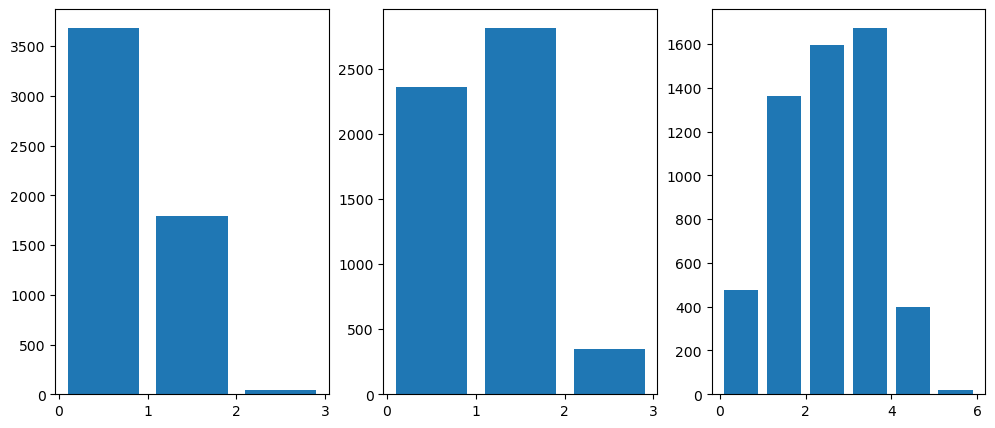

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,5))
ax1.hist(y_ICM,[0,1,2,3], rwidth=0.8)
ax2.hist(y_TE,[0,1,2,3], rwidth=0.8)
ax3.hist(y_Exp,[0,1,2,3,4,5,6], rwidth=0.8)

## Load high quality images

In [7]:
hq_blasts_info = np.load('data/CEM_database/high_quality_blastocysts_index.npy')

In [8]:
# ICM, TE, EXP Size, qualityTE, qualityZP

size2 = 1447200

size_arr = np.where(hq_blasts_info[:,3] == size2)[0]

tamaño2 = np.zeros_like(hq_blasts_info[:,0])
tamaño2[size_arr] = 1

highest_quality_indexes = np.where(hq_blasts_info[:,4]*hq_blasts_info[:,5]*tamaño2 == 1)[0]


# Segmentate images

In [9]:
im_height = 256
im_width = 256
#region = 'TE'
#model = model_loader(region)

"""
for i in highest_quality_indexes:
  print(i)
  img = img_to_array(load_img(directory + str(i) +'.jpg', grayscale=True))
  size = img.size

  img = resize(img, (im_width, im_height, 1), mode='constant', preserve_range=True, anti_aliasing=True)

  img = cv.normalize(img,  None, 0, 1, cv.NORM_MINMAX)
  img = np.expand_dims(img, [0])

  segmented_image = model.predict(img)
  segmented_threshold_image = (segmented_image > 0.5).astype(np.float32)
  segmented_image = segmented_threshold_image.squeeze()

  min_val = np.min(segmented_image)
  max_val = np.max(segmented_image)
  normalized_image = ((segmented_image - min_val) / (max_val - min_val)) * 255

  # Convierte tu array NumPy normalizado a una imagen PIL
  image_pil = Image.fromarray(normalized_image.astype(np.uint8))

  # Convierte la imagen a un modo compatible para BMP (por ejemplo, 'L' para escala de grises)
  image_pil = image_pil.convert('L')  # Cambia 'L' al modo que corresponda a tu imagen

  # Guarda la imagen como un archivo BMP
  image_pil.save('data/segmented_CEM_database/GT_'+str(region)+'/' +str(i)+ '.bmp')
  clear_output()
"""

"\nfor i in highest_quality_indexes:\n  print(i)\n  img = img_to_array(load_img(directory + str(i) +'.jpg', grayscale=True))\n  size = img.size\n\n  img = resize(img, (im_width, im_height, 1), mode='constant', preserve_range=True, anti_aliasing=True)\n\n  img = cv.normalize(img,  None, 0, 1, cv.NORM_MINMAX)\n  img = np.expand_dims(img, [0])\n\n  segmented_image = model.predict(img)\n  segmented_threshold_image = (segmented_image > 0.5).astype(np.float32)\n  segmented_image = segmented_threshold_image.squeeze()\n\n  min_val = np.min(segmented_image)\n  max_val = np.max(segmented_image)\n  normalized_image = ((segmented_image - min_val) / (max_val - min_val)) * 255\n\n  # Convierte tu array NumPy normalizado a una imagen PIL\n  image_pil = Image.fromarray(normalized_image.astype(np.uint8))\n\n  # Convierte la imagen a un modo compatible para BMP (por ejemplo, 'L' para escala de grises)\n  image_pil = image_pil.convert('L')  # Cambia 'L' al modo que corresponda a tu imagen\n\n  # Guarda l

In [10]:
directory = 'data/CEM_database/'
directory_TE = 'data/segmented_CEM_database/GT_TE/'
directory_ZP = 'data/segmented_CEM_database/GT_ZP/'

non_blurry_images = []

# Get the list of .jpg files in the main directory
jpg_files = [f for f in os.listdir(directory) if f.endswith(".jpg")]

for filename_bmp in os.listdir(directory_TE):
    if filename_bmp.endswith(".bmp"):
        # Construct the corresponding .jpg filename
        filename_jpg = os.path.splitext(filename_bmp)[0] + ".jpg"

        # Check if the corresponding .jpg file exists in the main directory
        if filename_jpg in jpg_files:
            file_path_TE = os.path.join(directory_TE, filename_bmp)
            file_path_ZP = os.path.join(directory_ZP, filename_bmp)

            # Open the BMP image
            img_TE = Image.open(file_path_TE)
            img_ZP = Image.open(file_path_ZP)

            # Convert the image to a NumPy array
            img_array_TE = np.array(img_TE)
            img_array_ZP = np.array(img_ZP)

            flooded_image_TE = flood_fill(img_array_TE, (0, 0), 255)
            flooded_image_ZP = flood_fill(img_array_ZP, (0, 0), 255)

            # Check the mean condition for non-blurry images
            if (np.mean(flooded_image_TE) < 250) and (np.mean(flooded_image_ZP) < 250):
                # Append the filename (converted to an integer if possible)
                non_blurry_images.append(int(os.path.splitext(filename_jpg)[0]))

# Print the list of non-blurry images
print(non_blurry_images)


# Load sample data

## Load sample labels

In [ ]:
sample_index = 39  # Specifying the index of the image to be loaded

# Loading images for different categories/types from respective directories
img_ICM = load_image('data/segmented_CEM_database/GT_ICM', sample_index)  # Loading an image from 'GT_ICM' directory
img_TE = load_image('data/segmented_CEM_database/GT_TE', sample_index)  # Loading an image from 'GT_TE' directory
img_ZP = load_image('data/segmented_CEM_database/GT_ZP', sample_index)  # Loading an image from 'GT_ZP' directory
img_Blast = load_image('data/CEM_database', sample_index, jpeg=True)  # Loading an image from 'Images' directory


## Define sample labels

In [ ]:
images = [img_ICM, img_ZP, img_TE]  # Storing a list of loaded images in different categories

# Generating different types of labels based on the images
initial_labels, sum_labels, filled_labels_2, filled_labels_3 = mix_labels(images)

# Collecting all generated labels into a single variable
all_labels = initial_labels, sum_labels, filled_labels_2, filled_labels_3


### Define titles

In [ ]:
titles = ['Image 1', 'Image 2', 'Image 3']
sum_titles = ['Sum 2+1', 'Sum 3+1', 'Sum 3+2']
filled_titles_2 = [
    'Filled Image 2',
    'Filled Image 2 - 2',
    'Filled Image 2 - 2 - 1'
]
filled_titles_3 = [
    'Filled Image 2 - 3',
    'Filled Image 3 - 3',
    'Filled Image 3 - 3 - 1'
]

## Plot sample labels

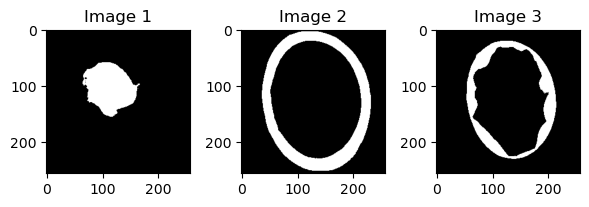

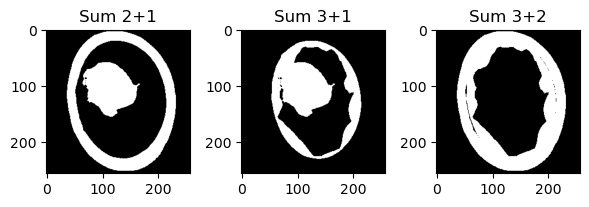

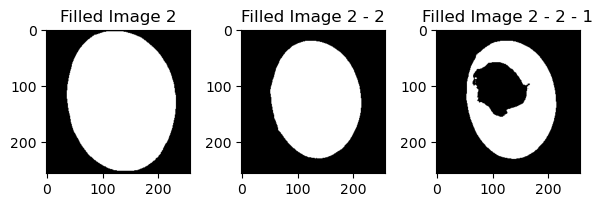

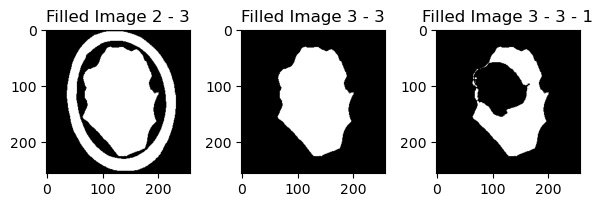

In [ ]:
# Plotting images associated with initial labels using titles
plot_images(initial_labels, titles)

# Plotting images associated with sum labels using sum_titles
plot_images(sum_labels, sum_titles)

# Plotting images associated with filled labels 2 using filled_titles_2
plot_images(filled_labels_2, filled_titles_2)

# Plotting images associated with filled labels 3 using filled_titles_3
plot_images(filled_labels_3, filled_titles_3)


## Plot sample image masked

In [ ]:
%run utils/segmentation_functions.py

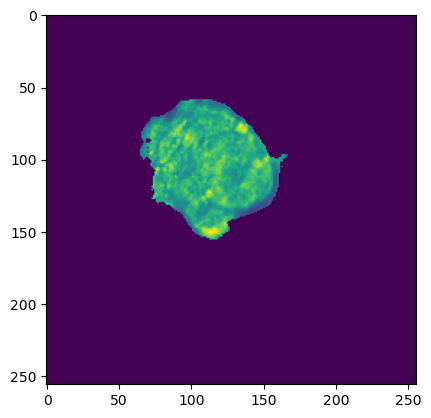

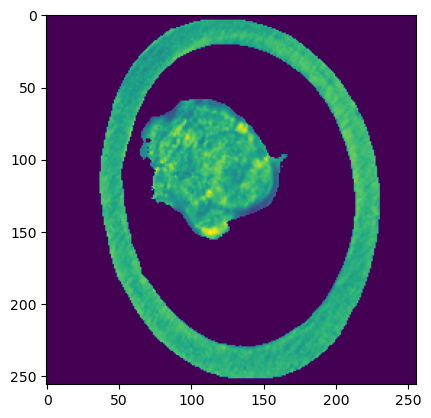

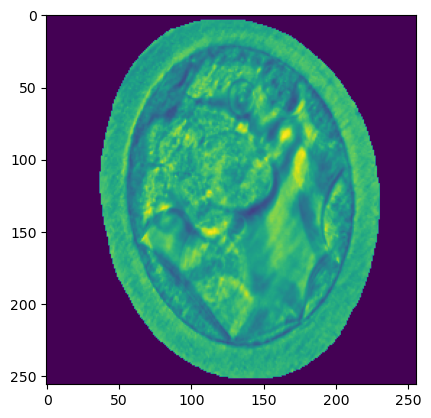

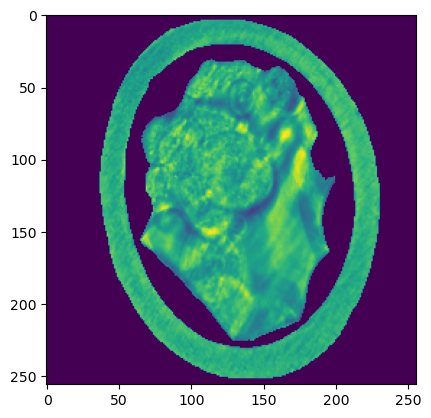

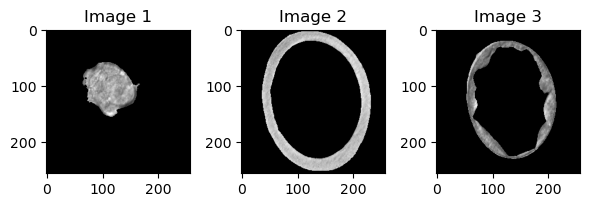

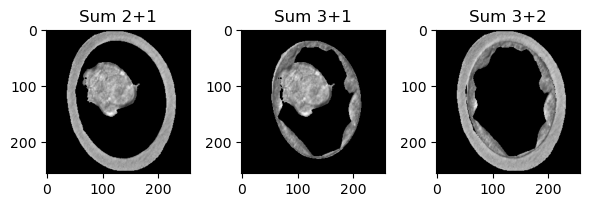

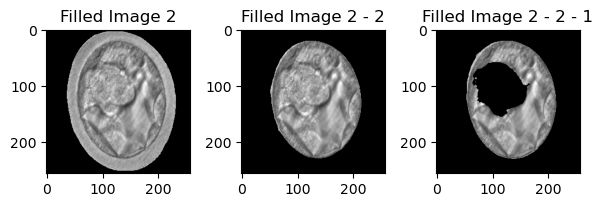

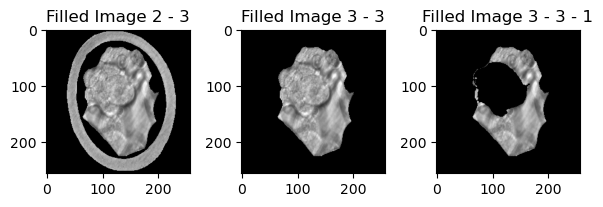

In [ ]:
#img_Blast = load_image('data/CEM_database', sample_index, jpeg=True)  # Loading an image from 'Images' directory
#img_Blast = resize(img_Blast, (im_width, im_height, 1), mode='constant', preserve_range=True, anti_aliasing=True)
#img_Blast = np.swapaxes(np.swapaxes(img_Blast,0,2),1,2)


# Applying segmentation on images based on initial labels
masked_images = segmentate_images(img_Blast, initial_labels)

# Applying segmentation on images based on sum labels
masked_sum_images = segmentate_images(img_Blast, sum_labels)

# Applying segmentation on images based on filled labels 2
masked_filled_images_2 = segmentate_images(img_Blast, filled_labels_2)

# Applying segmentation on images based on filled labels 3
masked_filled_images_3 = segmentate_images(img_Blast, filled_labels_3)

# Plotting segmented images associated with initial labels using titles
plot_images(masked_images, titles)

# Plotting segmented images associated with sum labels using sum_titles
plot_images(masked_sum_images, sum_titles)

# Plotting segmented images associated with filled labels 2 using filled_titles_2
plot_images(masked_filled_images_2, filled_titles_2)

# Plotting segmented images associated with filled labels 3 using filled_titles_3
plot_images(masked_filled_images_3, filled_titles_3)


## Plot sample labels cropped

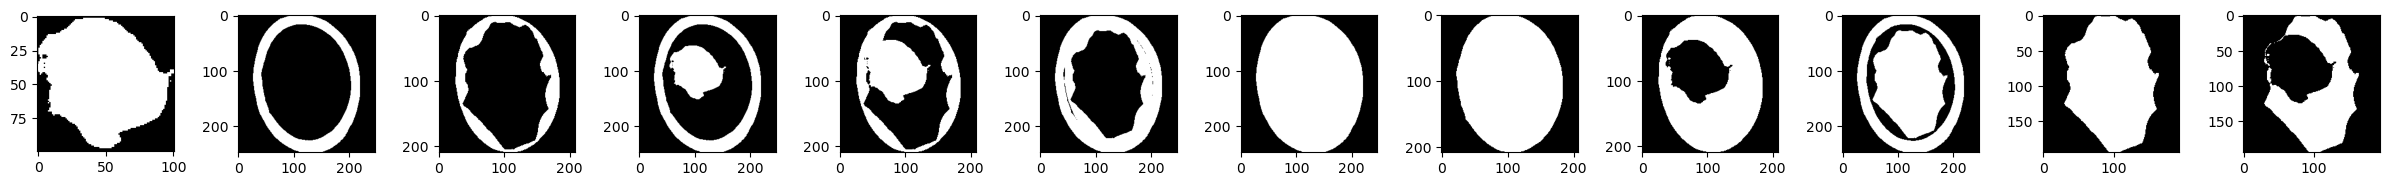

In [ ]:
# List to store cropped labels after processing
cropped_labels = []

# Combine all labels from different sources into a single list
all_labels = initial_labels + sum_labels + filled_labels_2 + filled_labels_3

# Iterate through all collected labels for cropping
for labels in all_labels:
    # Crop binary image to remove unnecessary whitespace
    cropped_label = crop_binary_image(labels)
    # Append cropped labels to the list
    cropped_labels.append(cropped_label)

# Plotting the cropped labels as images
plot_images(cropped_labels)


# Feature extraction    

## Feature extraction arguments

In [ ]:
# Total number of data points
n_data = 250  # Assigns the value 250 to the variable n_data
n_data = 10

# Define arguments for TE zone
min_distance = 10  # Minimum distance parameter
threshold = 0.005  # Threshold value
height = 0  # Height parameter
window_length = 10  # Window length
polyorder = 2  # Polynomial order
arguments_TE = [window_length, polyorder, min_distance, threshold, height]  # Stores parameters for TE zone

# Duplicate arguments for ZP zone
arguments_ZP = arguments_TE.copy()  # Creates a copy of arguments for ZP, same as TE

# Redefine arguments for ICM zone
min_distance = 10  # New minimum distance
threshold = 0.02  # New threshold
height = 0  # New height
window_length = 10  # New window length
polyorder = 2  # New polynomial order
arguments_ICM = [window_length, polyorder, min_distance, threshold, height]  # Stores parameters for ICM zone

# Grouping arguments for different zones
arguments_zones = [arguments_TE, arguments_ZP, arguments_ICM]  # Combines parameters for all zones

# Visualization options for polar, cells, and cell divisions
vis_polar = False  # Visualization option for polar
vis_cells = False  # Visualization option for cells
vis_cell_divisions = False  # Visualization option for cell divisions
vis_arguments = [vis_polar, vis_cells, vis_cell_divisions]  # Stores visualization options

# Train with all features, or only the ones from the chosen region
region_specific = False

# Region to analyze (only if region_specific = True)
region = 'ICM'

## Feature extraction process

  0%|          | 0/1295 [00:00<?, ?it/s]

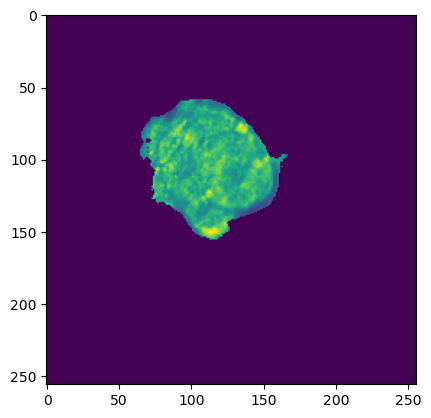

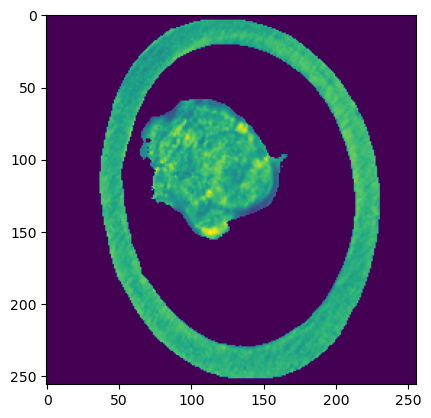

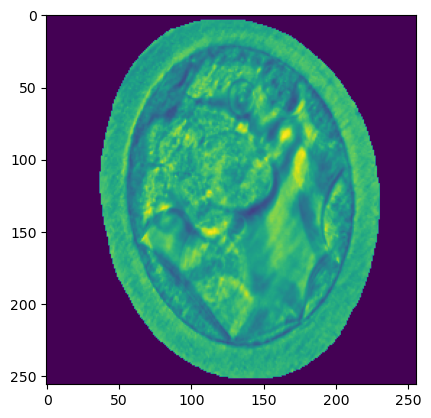

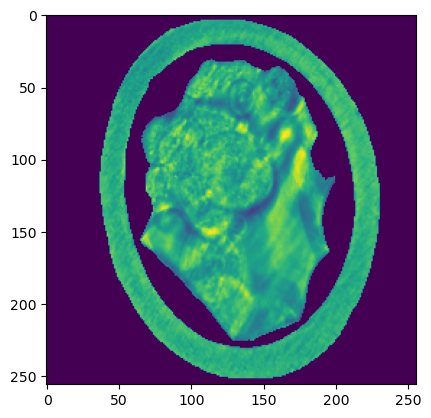

  0%|          | 0/1295 [00:01<?, ?it/s]


ValueError: The parameter `image` must be a 2-dimensional array

In [ ]:
sorted_indexes = np.sort(non_blurry_images)
features, independent_features = feature_extraction_full_dataset_CEM(sorted_indexes, arguments_zones, vis_arguments, n_data)

## Separate all independent features

In [ ]:
all_ICM_features = []
all_ZP_features = [] 
all_TE_features = []

for i in np.arange(len(independent_features)):
    textural_ICM_features = independent_features[i][0][0]
    textural_ZP_features = independent_features[i][0][1]
    textural_TE_features = independent_features[i][0][2]

    topographic_ICM_features = independent_features[i][2][0]
    topographic_TE_features = independent_features[i][2][1]
    topographic_ZP_features = independent_features[i][2][2]

    geometric_ICM_features_1 = independent_features[i][1][0][0]
    geometric_ICM_features_2 = independent_features[i][1][1][0]
    geometric_ICM_features_3 = independent_features[i][1][2][0]
    geometric_ICM_features_4 = independent_features[i][1][3][0]
    geometric_ICM_features = [geometric_ICM_features_1, geometric_ICM_features_2, geometric_ICM_features_3, geometric_ICM_features_4]

    geometric_ZP_features_1 = independent_features[i][1][0][1]
    geometric_ZP_features_2 = independent_features[i][1][1][1]
    geometric_ZP_features_3 = independent_features[i][1][2][1]
    geometric_ZP_features_4 = independent_features[i][1][3][1]
    geometric_ZP_features = [geometric_ZP_features_1, geometric_ZP_features_2, geometric_ZP_features_3, geometric_ZP_features_4]


    geometric_TE_features_1 = independent_features[i][1][0][2]
    geometric_TE_features_2 = independent_features[i][1][1][2]
    geometric_TE_features_3 = independent_features[i][1][2][2]
    geometric_TE_features_4 = independent_features[i][1][3][2]
    geometric_TE_features = [geometric_TE_features_1, geometric_TE_features_2, geometric_TE_features_3, geometric_TE_features_4]

    all_ICM_features_un_blast = textural_ICM_features + topographic_ICM_features + geometric_ICM_features
    all_ZP_features_un_blast = textural_ZP_features + topographic_ZP_features + geometric_ZP_features
    all_TE_features_un_blast = textural_TE_features + topographic_TE_features + geometric_TE_features

    all_ICM_features.append(all_ICM_features_un_blast)
    all_ZP_features.append(all_ZP_features_un_blast) 
    all_TE_features.append(all_TE_features_un_blast)
    

In [ ]:
# Sanity check 1

print(len(all_ICM_features))
print(len(all_ZP_features))
print(len(all_TE_features))

# Sanity check 2

print(len(independent_features[0])) # textural / geometric / topographic 
print(len(independent_features[0][0])) # ICM / ZP / TE
print(len(independent_features[0][1])) # all_volumes + all_perimeters + all_ratios + all_soitar
print(len(independent_features[0][1][0])) # ICM / ZP / TE
print(len(independent_features[0][2])) # ICM / TE / ZP

9
9
9
3
3
4
3
3


# Load labels

In [ ]:
selected_index = non_blurry_images.copy()
blast_quality = np.vstack((y_Exp[selected_index], y_ICM[selected_index], y_TE[selected_index]))

In [ ]:
if region == 'ICM':
    selected_features = all_ICM_features
if region == 'TE':
    selected_features = all_TE_features
if region == 'ZP':
    selected_features = all_ZP_features

In [ ]:
fila_aux_1 = np.vectorize(str)(blast_quality[0])
fila_aux_2 = np.vectorize(str)(blast_quality[1])
fila_aux_3 = np.vectorize(str)(blast_quality[2])

In [ ]:
for r in np.arange(len(blast_quality[0])):
    if fila_aux_2[r] == '0':
        fila_aux_2[r] = 'A'
    if fila_aux_2[r] == '1':
        fila_aux_2[r] = 'B'
    if fila_aux_2[r] == '2':
        fila_aux_2[r] = 'C'
        
    if fila_aux_3[r] == '0':
        fila_aux_3[r] = 'A'
    if fila_aux_3[r] == '1':
        fila_aux_3[r] = 'B'
    if fila_aux_3[r] == '2':
        fila_aux_3[r] = 'C'
    
blast_quality = np.vstack((fila_aux_1,fila_aux_3,fila_aux_3)).T

In [ ]:
# Call the function 'choose_region' to obtain the dataset for the 'ICM' region
# The function returns 'X' and 'y', representing the features and labels, respectively

if region_specific: # train with only the region-specific features use:
    X, y = choose_region(region, n_data, selected_features, blast_quality)
else:
    X, y = choose_region(region, n_data, features, blast_quality)

In [ ]:
X

array([[  34., 2207.,    0., ...,    0.,    0.,    0.],
       [  25., 1184.,    0., ...,    0.,    0.,    0.],
       [  13.,  315.,    0., ...,    0.,    0.,    0.],
       ...,
       [  19.,  712.,    0., ...,    0.,    0.,    0.],
       [  11.,  259.,    0., ...,    0.,    0.,    0.],
       [   9.,  181.,    0., ...,    0.,    0.,    0.]])

# Creo el dataset

In [126]:
class EmbryoDataset(Dataset):
    def __init__(self, img_dir, labels, selected_index, region_specific=False, region=None):

        self.img_labels = labels[selected_index]  # Store the image labels
        self.img_dir = img_dir  # Store the directory containing the images
        self.region_specific = region_specific
        self.selected_index = selected_index
        
        if region_specific:
            self.region = region
            self.mask_dir = 'data/segmented_CEM_database/GT_' + region

        # Define a series of image transformations using torchvision's Compose
        self.transform = T.Compose([
            T.Pad(100, padding_mode='reflect'),  # Padding the images
            T.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally with a 50% probability
            T.RandomRotation(degrees=(0, 350), fill=100),  # Randomly rotate the image between -10 and 10 degrees
            T.Resize((400, 400)),  # Resize the image to (400, 400)
            T.CenterCrop(300),  # Center crop the resized image to a final size of (300, 300)
            T.ToTensor()  # Convert the image to a PyTorch tensor
        ])

    def __len__(self):
        return len(self.img_labels)  # Return the total number of images in the dataset

    def __getitem__(self, idx):
        i = self.selected_index[idx]
        img_path = os.path.join(self.img_dir, str(i)+'.jpg')
        image = img_to_array(load_img(img_path))

        image = np.uint8(image.squeeze())
        label = self.img_labels[idx]
        image = Image.fromarray(image)  # Convert the image to a PIL Image
        image = self.transform(image)

        if self.region_specific:
            mask_path = os.path.join(self.mask_dir, str(idx + 1) + '.bmp')
            mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)  # Read the image using OpenCV
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)  # Convert the image from BGR to RGB format
            mask = Image.fromarray(mask)  # Convert the image to a PIL Image
            mask = self.transform(mask)  # Apply the defined transformations to the image
            image = image * mask

        return image, label  # Return the transformed image and its label


## Create test y training datasets

# Training

In [128]:
img_dir = 'data/CEM_database'  # Directory containing image data

model_name = 'vgg16'  # Aquí elige el modelo que quieras utilizar

# Define el número de pliegues para la validación cruzada
num_folds = 10  # Por ejemplo, utiliza 10-fold cross-validation
num_folds = 2  # O 2 para ir más rápido en la prueba

# Definición de otros hiperparámetros
learning_rate = 0.001
batch_size = 16
num_epochs = 2

size2 = 1447200
train_proportion = 0.8
valid_proportion = 0.2

labels = y_ICM

selected_index = non_blurry_images.copy()

In [129]:
# Crea un objeto KFold para dividir tus datos
kf = KFold(n_splits=num_folds, shuffle=True)

# Creación del modelo elegido
model = get_pretrained_model(model_name)

# Resto del código para el entrenamiento
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Seleccionar el optimizador
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Instancio el dataset
region_specific=False #Activates or deactivates choosing only the features of a single region (or all)
region=None           #Chooses region (only if region_specific=True)
InstancedEmbryoDataset = EmbryoDataset(img_dir, labels, selected_index, region_specific, region)

# Loop sobre los pliegues (folds)
for fold, (train_index, val_index) in enumerate(kf.split(InstancedEmbryoDataset)):
    print(f"Fold {fold + 1}/{num_folds}")

    loader_train, loader_val = create_dataloaders(InstancedEmbryoDataset,
                                                  labels, 
                                                  selected_index,
                                                  train_index,
                                                  val_index,
                                                  region_specific,
                                                  region,
                                                  img_dir)


    train_loss, train_acc = train_one_epoch(model, optimizer, loader_train, device)
    print(f"Epoch [{fold + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    val_acc = accuracy(loader_val, model, device)
    print(f"Epoch [{fold + 1}/{num_epochs}], Validation Acc: {val_acc:.4f}")


Fold 1/2


100%|██████████| 21/21 [13:01<00:00, 37.20s/it]


Epoch [1/2], Train Loss: 3.0105, Train Acc: 0.2890
Checking accuracy
Got 259 / 648 correct (39.97%)
Epoch [1/2], Validation Acc: 0.3997
Fold 2/2


 57%|█████▋    | 12/21 [08:50<06:38, 44.23s/it]


KeyboardInterrupt: 

In [92]:
np.where(selected_index == np.int64(5335))

(array([], dtype=int64),)

In [87]:
selected_index

[4483,
 4497,
 2780,
 3475,
 5004,
 3307,
 3461,
 4326,
 5038,
 2757,
 4454,
 4332,
 251,
 3878,
 4871,
 3850,
 3111,
 5212,
 2233,
 4124,
 3887,
 4130,
 4905,
 4093,
 3930,
 5399,
 4939,
 5414,
 5372,
 4078,
 3071,
 5428,
 4044,
 2435,
 1882,
 4291,
 2186,
 4285,
 3501,
 682,
 4508,
 3273,
 1464,
 1302,
 3515,
 2623,
 4252,
 2145,
 5158,
 3528,
 5159,
 4253,
 1465,
 3272,
 5165,
 3500,
 4509,
 3266,
 4290,
 3299,
 2187,
 1883,
 4723,
 3058,
 2346,
 1897,
 4051,
 5367,
 3716,
 5401,
 5415,
 5398,
 3931,
 4938,
 4092,
 3925,
 4904,
 4910,
 3886,
 3662,
 5213,
 3676,
 4119,
 5207,
 3845,
 3851,
 3879,
 4870,
 250,
 2756,
 4441,
 5011,
 5005,
 3474,
 3312,
 2781,
 4482,
 4480,
 2797,
 3489,
 3462,
 5007,
 4331,
 2740,
 252,
 3847,
 4682,
 3106,
 4669,
 5211,
 5205,
 3674,
 2224,
 2542,
 3884,
 2556,
 3890,
 4127,
 4641,
 4899,
 4906,
 4912,
 4090,
 3099,
 3714,
 3700,
 5371,
 5417,
 3066,
 4721,
 1659,
 4053,
 4286,
 2191,
 5167,
 3270,
 3264,
 681,
 4245,
 4537,
 4251,
 3259,
 2621,
 424